# 2. Q-Learning

## 2.1 Learning from experts

In [313]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv
from Q_learning import eps_policy, eps_policy_self_practice
from helpers import plot_grids_heatmap, format_val
import pickle
env = TictactoeEnv()
Train=False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### **Question 1**: Plot average reward for every 250 games during training – i.e. after the 50th game, plot the average reward of the first 250 games, after the 100th game, plot the average reward of games 51 to 100, etc. Does the agent learn to play Tic Tac Toe?

In [314]:
train_q1 = False
if Train or train_q1:
    eps_agents = np.arange(0,1,0.1)
    rewards = []
    for eps_agent in eps_agents:
        print('Started learning with eps_agent={:.1f}'.format(eps_agent))
        _, rewards_250 = eps_policy(env, Q_table=dict(), eps_agent=eps_agent)
        rewards.append(rewards_250)

    with open("./rewards/q1", "wb") as fp:
        pickle.dump((eps_agents, rewards), fp)
else:
    with open("./rewards/q1", "rb") as fp:
        eps_agents, rewards = pickle.load(fp)


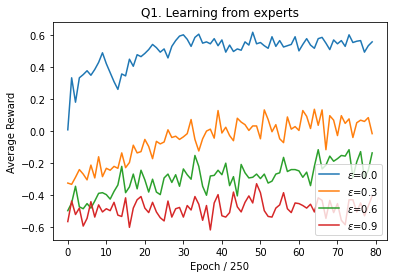

In [315]:
indices = [0, 3, 6, 9] #Corresponds to 0.0, 0.3, 0.6 and 0.9
for ind in indices:
    plt.plot(rewards[ind], label=r'$\epsilon$=' + '{:.1f}'.format(eps_agents[ind]))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q1. Learning from experts')
plt.legend(loc='lower right')
plt.savefig('./plots/q1.png')
plt.show()


### 2.1.1 Decreasing exploration

#### **Question 2**: Plot average reward for every 250 games during training. Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of n* ?


In [316]:
train_q2 = False
if Train or train_q2:
    expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
    expl_rewards = []
    for nb_expl_games in expl_games:
        print('Started learning with n*={}'.format(nb_expl_games))
        _, rewards_expl_250 = eps_policy(env, Q_table=dict(), decay_eps=True, expl_games=nb_expl_games)
        expl_rewards.append(rewards_expl_250)

    with open("./rewards/q2", "wb") as fp:
        pickle.dump((expl_rewards, expl_games), fp)
else:
    with open("./rewards/q2", "rb") as fp:
        expl_rewards, expl_games = pickle.load(fp)


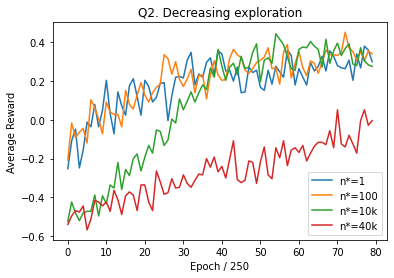

In [317]:
indices = [0, 2, 5, 7]
for ind in indices:
    plt.plot(expl_rewards[ind], label='n*=' + format_val(expl_games[ind]))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q2. Decreasing exploration')
# plt.title('Average rewards after every 250 games with different values of n*')
plt.legend()
plt.savefig('./plots/q2.png')
plt.show()

#### **Question 3**: After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents – when measuring the ‘test’ performance, put $\epsilon$ = 0 and do not update the Q-values. Plot Mopt and Mrand over time. Describe the differences and the similarities between these curves and the ones of the previous question.


In [318]:
train_q3 = False
if Train or train_q3:
    expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for nb_expl_games in expl_games:
        print('Started learning with n*={}'.format(nb_expl_games))
        _, M_opts, M_rnds = eps_policy(env, Q_table=dict(), decay_eps=True, expl_games=nb_expl_games, eval_every=250)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q3", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games), fp)
else:
    with open("./rewards/q3", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games = pickle.load(fp)



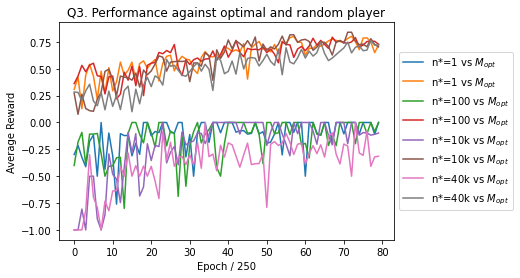

In [319]:
indices = [0, 2, 5, 7]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label='n*=' + format_val(expl_games[ind]) + ' vs ' + r"$M_{opt}$")
    plt.plot(eps_vs_rnd_rewards[ind], label='n*=' + format_val(expl_games[ind]) + ' vs ' + r"$M_{opt}$")
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q3. Performance against optimal and random player')
plt.savefig('./plots/q3.png', bbox_inches='tight')
plt.show()

### 2.1.2 Good expoerts and bad experts

In [320]:
best_expl_games = 10000

#### **Question 4**: After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents – for each value of $\epsilon_{opt}$. Plot $M_{opt}$ and $M_{rand}$ over time. What do you observe? How can you explain it?


In [321]:
train_q4 = False
if Train or train_q4:
    eps_opts = np.arange(0,1,0.1)
    eps_rewards = []
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for eps_opt in eps_opts:
        print('Started learning with eps_opt={:.1f}'.format(eps_opt))
        _, M_opts, M_rnds = eps_policy(env, Q_table=dict(), eps_opt=eps_opt, decay_eps=True, expl_games=best_expl_games, eval_every=250)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q4", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_opts), fp)
else:
    with open("./rewards/q4", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_opts = pickle.load(fp)

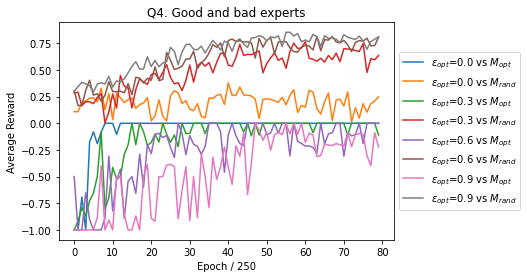

In [322]:
indices=[0, 3, 6, 9]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label=r"$\epsilon_{opt}$=" + '{:.1f} vs '.format(eps_opts[ind]) + r"$M_{opt}$")
    plt.plot(eps_vs_rnd_rewards[ind], label=r"$\epsilon_{opt}$=" + '{:.1f} vs '.format(eps_opts[ind]) + r"$M_{rand}$")
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q4. Good and bad experts')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig('./plots/q4.png', bbox_inches='tight')
plt.show()

In [331]:

print('Started learning with eps_opt=1')
_, M_opts, M_rnds = eps_policy(env, Q_table=dict(), eps_opt=1, decay_eps=True, expl_games=10000, eval_every=250)




Started learning with eps_opt=1


  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
plt.plot(M_opts, label=r"$\epsilon_{opt}$=" + '1 vs '.format(eps_opts[ind]) + r"$M_{opt}$")
plt.plot(M_rnds, label=r"$\epsilon_{opt}$=" + '1 vs '.format(eps_opts[ind]) + r"$M_{rand}$")
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
# plt.savefig('./plots/q4.png', bbox_inches='tight')
plt.show()

#### **Question 5**: What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?

In [323]:
print('Best M_opt after 20000 games: {:.3f}'.format(np.max(eps_vs_opt_rewards)))
print('Best M_rnd after 20000 games: {:.3f}'.format(np.max(eps_vs_rnd_rewards)))

Best M_opt after 20000 games: 0.000
Best M_rnd after 20000 games: 0.868


The highest $\begin{aligned}M_{opt}\end{aligned}$ is equal to 0. This is normal and to be awaited since if correctly played, a player never losses. Thus the optimal player will never loose. If now the agent has played and learned enough, then he will also never loose. This will result in all games ending in a draw.

The highest $\begin{aligned}M_{rand}\end{aligned}$ is equal to 0.882. This value is pretty high but is not out of the ordinary since if correctly played, a player never losses. Thus the optimal player will never loose. If now the agent has played and learned enough, then he will also never loose. This will result in all games ending in either a win for the agent or a draw.



#### **Question 6**: Assume that Agent 1 learns by playing against Opt(0) and find the optimal Q-values Q1(s, a). In addition, assume that Agent 2 learns by playing against Opt(1) and find the optimal Q-values Q2(s, a). Do Q1(s, a) and Q2(s, a) have the same values?

The answer is no. Since Agent 1 plays against an optimal player who always chooses the best action, the game always ends in either a draw or a loose for Agent 1. This means that all the Q-values of Agent 1 will be smaller or equal 0 since the only possibility to obtain a positive reward is by winning a game. On the other hand, Agent 2 will win most of its games and never loose once he has learned the optimal Q-values. Thus he will have Q-values that are greater then 0.

### Learning by self-practive

#### **Question 7**:  After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different values of $\epsilon$ ∈ [0, 1). Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$?

In [324]:
train_q7 = False
if Train or train_q7:
    eps_agents = np.arange(0, 1, 0.1)
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for eps_agent in eps_agents:
        print('Started learning with eps_agent={:.1f}'.format(eps_agent))
        _, M_opts, M_rnds = eps_policy_self_practice(env, Q_table=dict(), eps_agents=eps_agent)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q7", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_agents), fp)
else:
    with open("./rewards/q7", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_agents = pickle.load(fp)

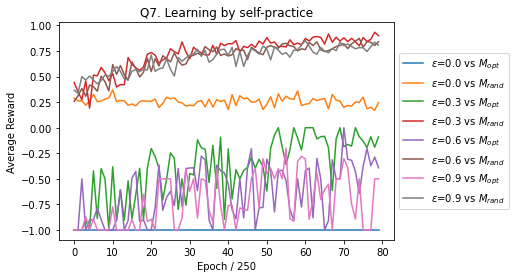

In [325]:
indices=[0, 3, 6, 9]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label=r"$\epsilon$=" + '{:.1f} vs '.format(eps_opts[ind]) + r"$M_{opt}$")
    plt.plot(eps_vs_rnd_rewards[ind], label=r"$\epsilon$=" + '{:.1f} vs '.format(eps_opts[ind]) + r"$M_{rand}$")
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q7. Learning by self-practice')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig('./plots/q7.png', bbox_inches='tight')
plt.show()

#### **Question 8**: After every 250 games during training, compute the ‘test’ Mopt and Mrand for your agents. Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of n*?


In [326]:
train_q8 = False
if Train or train_q8:
    expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for expl_game in expl_games:
        print('Started learning with expl_game={:.1f}'.format(expl_game))
        Q_table, M_opts, M_rnds = eps_policy_self_practice(env, Q_table=dict(), decay_eps=True, expl_games=expl_game)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q8", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games), fp)
else:
    with open("./rewards/q8", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games = pickle.load(fp)

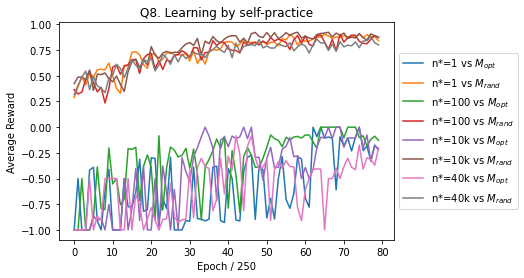

In [327]:
indices = [0, 2, 5, 7]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label='n*=' + format_val(expl_games[ind]) + ' vs ' + r"$M_{opt}$")
    plt.plot(eps_vs_rnd_rewards[ind], label='n*=' + format_val(expl_games[ind]) + ' vs ' + r"$M_{rand}$")
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Q8. Learning by self-practice')
plt.savefig('./plots/q8.png', bbox_inches='tight')
plt.show()

#### Question 9: What are the highest values for Mopt and Mrand achieved after 20 000 games?

In [328]:
best_M_opt = max(max(eps_vs_opt_rewards))
best_M_rand = max(max(eps_vs_rnd_rewards))
print('Best M_opt: {}'.format(best_M_opt))
print('Best M_rand: {:.4f}'.format(best_M_rand))

Best M_opt: 0.0
Best M_rand: 0.9240


#### Question 10: 

In [329]:
best_expl_games = 10000
train_q10 = False
if Train or train_q10:
    print('Started learning with expl_game={}'.format(best_expl_games))
    Q_table, _, _ = eps_policy_self_practice(env, Q_table=dict(), nb_epochs=20000, decay_eps=True, expl_games=best_expl_games, eval_every=-1)

    with open("./rewards/q10", "wb") as fp:
        pickle.dump((Q_table), fp)
else:
    with open("./rewards/q10", "rb") as fp:
        Q_table = pickle.load(fp)

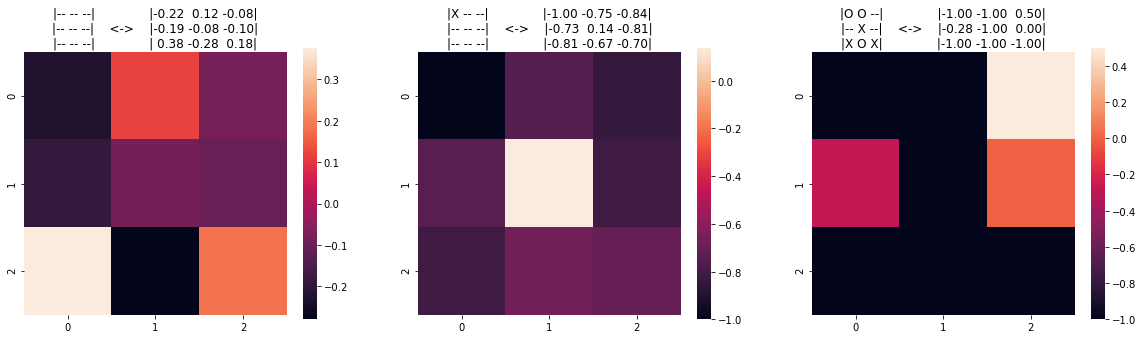

In [330]:
grid0 = np.array([[0,0,0],
                [0,0,0],
                [0,0,0]])

grid1 = np.array([[1,0,0],
                [0,0,0],
                [0,0,0]])

grid2 = np.array([[-1,-1,0],
                [0,1,0],
                [1,-1,1]])

plot_grids_heatmap(Q_table, [grid0, grid1, grid2])
plt.savefig('./plots/q10',  bbox_inches='tight')

# 3. Deep Q-Learning